<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/R_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')

# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])

aggiornamento al 2020-05-24


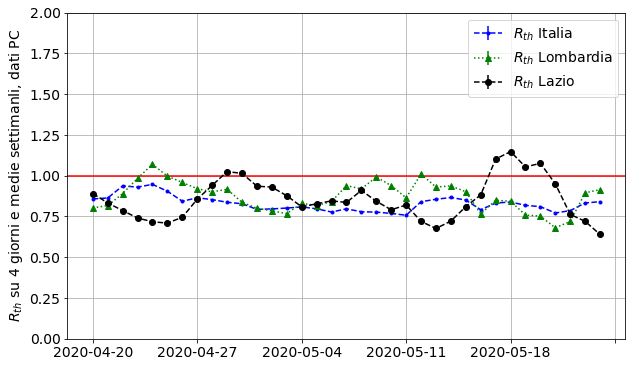

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data").copy()
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data").copy()

def Rth(data, N=7, d=4):
  # https://www.facebook.com/DatiAnalisiCoronavirus/posts/142436764043174?__tn__=K-R
  N=7
  y = np.convolve(data, np.ones((N,))/N, mode='valid')
  x = np.linspace(0, len(y), len(y))
  d=4 
  return x[d:] , y[d:]/y[:-d]


#fig.autofmt_xdate()
#x.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

data = df['nuovi_positivi']
xd , y = Rth(data)
cut = 50
x = np.array(df.iloc[cut+6:,0])
for i in range(len(x)):
  x[i]=x[i][0:10]
ax.errorbar(x , y[xd>cut], yerr=0, fmt='b.--', label='$R_{th}$ Italia')
data = Lombardia['nuovi_positivi']
xd , y = Rth(data)
ax.errorbar(x, y[xd>cut], yerr=0, fmt='g^:', label='$R_{th}$ Lombardia')
data = Lazio['nuovi_positivi']
xd , y = Rth(data)
ax.errorbar(x , y[xd>cut], yerr=0, fmt='ko--', label='$R_{th}$ Lazio')

ax.axhline(1, color='red')
#ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$ su 4 giorni e medie settimanli, dati PC')
ax.xaxis.set_major_locator(MultipleLocator(7))

ax.set_ylim(0,2)

ax.legend()
ax.grid()
plt.show()

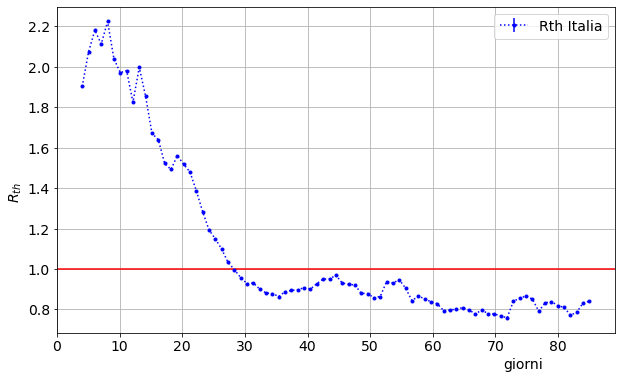

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
data = df['nuovi_positivi']
N=7
y = np.convolve(data, np.ones((N,))/N, mode='valid')
x = np.linspace(0, len(y), len(y))
d=4
y_past = y[:-d]
x_ = x[d:]
Rth = y[d:]/y_past
# ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
ax.errorbar(x_, Rth, yerr=0, fmt='b.:', label='Rth Italia')
ax.axhline(1, color='red')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$', horizontalalignment = 'left', y=0.4)

ax.legend()
ax.grid()
plt.show()